In [1]:
from imports import *
from defs import numberop, Sigma_minus, Sigma_plus, Sigma_x, Sigma_y, Sigma_z
from exactDiagMethods import Liouvillian, perform_exact_diag, build_exact_diag_hamiltonian, Enlarge_Matrix_site_j,output_exact_diag_results, Correlation_Matrix_i_Matrix_j, generate_random_state
from globalMethods import verify_density_matrix, build_initial_states, output_results
from vqteMethods import hamiltonian_generation_simple, hamiltonian_generation, perform_vqte

In [ ]:

def main():
    # Initialize the simulation parameters
    N= 1
    gamma=0.05
    eps=1
    mu_L=2
    mu_R=0.1
    T_L = 2
    T_R= 10
    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

    time = 100.0
    dt = 0.1
    nt = int(time/dt)
    exact_diag_ham= build_exact_diag_hamiltonian(N, eps)

    print(exact_diag_ham)
    exact_diag_init_state = generate_random_state(N)
    #ham_real, ham_imag = hamiltonian_generation(eps, gamma, F_L, F_R)

    #vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)

    # exact_diag_ham = build_exact_diag_hamiltonian(N,delta_list, J_list)

    # print(vqte_init_state)
    # print(exact_diag_init_state)

    # # Perform exact diagonalization
    exact_diag_results, time_points, steadyState = perform_exact_diag(gamma, F_L, F_R, dt, nt, exact_diag_init_state,exact_diag_ham,N, eps)

    # # Perform VQTE simulation
    # vqte_results, trace_list = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)
    # #Example VQE
    # # Output results
    output_exact_diag_results(exact_diag_results, time, nt, eps, mu_L,mu_R,T_L, T_R, time_points, steadyState)
    # output_results(vqte_results, exact_diag_results, time, nt, time_points, trace_list, steadyState)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]
Reference number operator expectation value: (0.9000254935899454-5.859247560904852e-17j)
Is Hermitian: True
Trace: (1.0000000000000002-3.851859888774472e-34j) (should be 1)
Eigenvalues: [0.00942032 0.01835067 0.04386914 0.09470052 0.14396539 0.15895816
 0.22204905 0.30868675]
All eigenvalues ≥ 0: True
Purity (Tr(ρ²)): (0.20190520322585337-2.1952401899507844e-18j) (should be 1 for pure state)
Initial expectation value of number operator: [np.float64(0.4354301216263441)]


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


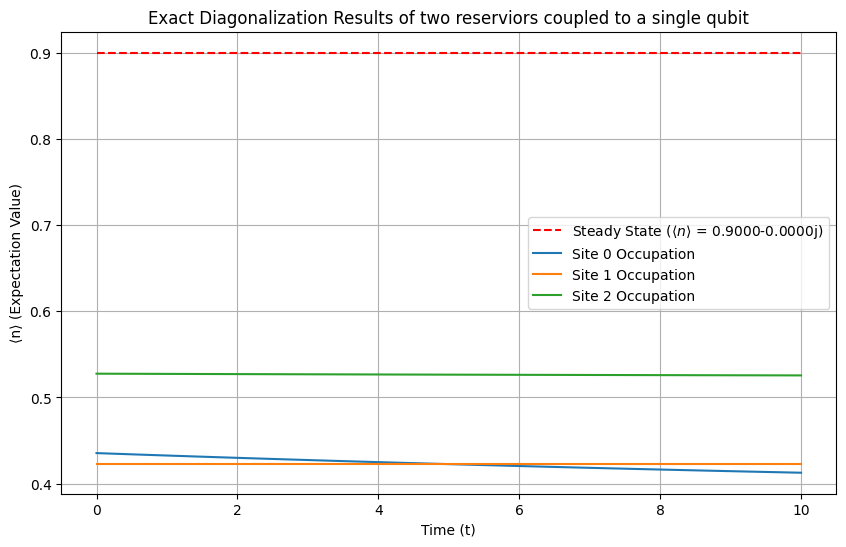

In [3]:
main()